# Convolutional NNs & Autoencoders
---

This project uses the `Quick Draw Dataset`, a collection of 50 million drawings across 345 categories, produced by players of a game Quick, Draw! `https://quickdraw.withgoogle.com/data`

Bitmap dataset contains drawings converted from vector to 28x28 grayscale images

Focus on subset of 10 classes of type 'body part'

The class labels are:

![listbodypart](./list_body_parts.png)

Aim to train a Convolutional NN (CNN) to try and use model to distinguish the classes. Then use autoencoder to learn a latent space representation of the dataset

## Preamble
---

In [1]:
# Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [2]:
# Keras import(s)
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

Load preprocessed dataset from np data file, which has already been split into training and testing parts 

- Each image reshaped to (N, N, 1) dimension, i.e. only one color dimension
- Images scaled to have intensities range [0, 1] as required for input to NN
- Shuffled for both training and testing sets separately 


In [3]:
#Load quickdraw bodyparts dataset
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 

In [4]:
print ('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)

Training: (160000, 28, 28, 1) (160000,)
Testing: (40000, 28, 28, 1) (40000,)


In [5]:
#Image labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

In [6]:
# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


## Image visualisation
---

#### Display some images of the training dataset (one for each type), and check that the associated label makes sense

In [7]:
#Find indices for first instance of each body part

indices = []

for i in range(10):

    index = np.where(y_train == i)[0][0]

    indices.append(index)

print (indices)

[6, 14, 0, 11, 5, 3, 34, 4, 8, 1]


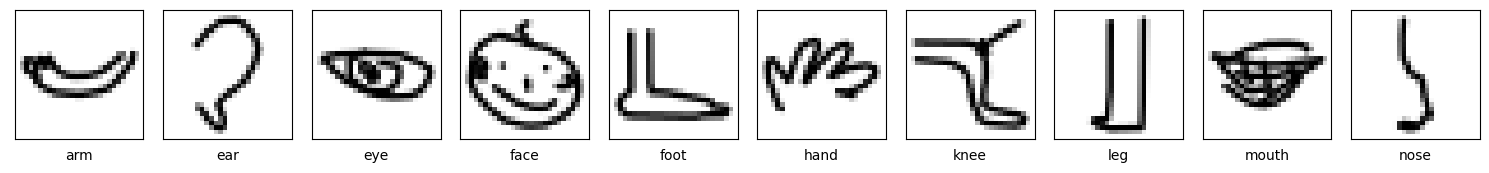

In [8]:
#Plot one of each body part

fig, ax = plt.subplots(1, 10, figsize = (15,15))

for i in range(10):

    part_index = indices[i]
    ax[i].imshow(X_train[part_index], cmap = plt.cm.binary)
    type = y_train[part_index].astype(int)
    ax[i].set_xlabel(body_parts[type])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.tight_layout();

#### Display first 25 images of the training dataset

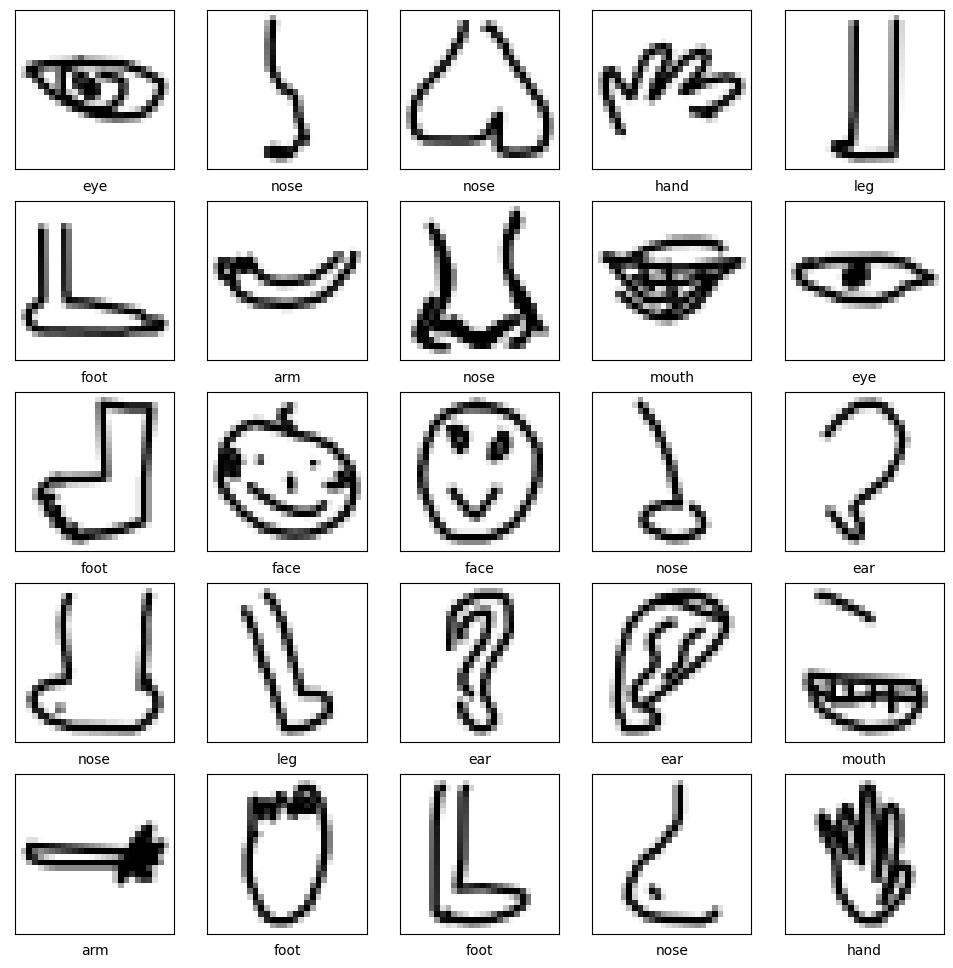

In [9]:
plt.figure(figsize = (12, 12))

for n in range(25):

    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(X_train[n], cmap = plt.cm.binary)

    # chart formatting
    type = y_train[n].astype(int)
    plt.xlabel(body_parts[type])
    plt.xticks([])
    plt.yticks([])

#### Investigate different kernels to an image of type face

Picked the first face in the training dataset

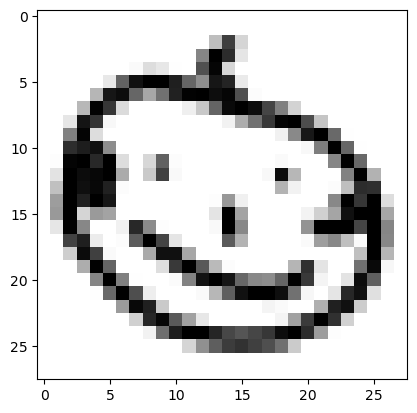

In [10]:
myface = X_train[11]

plt.imshow(myface, cmap = plt.cm.binary);

Define 4 kernels as 3x3 np arrays and add to dict of kernels:
- identity
- edge_detection 
- sharpening
- blurring

In [11]:
k_identity = np.array([[[0],[0],[0]], [[0],[1],[0]], [[0],[0],[0]]])
k_edge= np.array([[[-1],[-1],[-1]], [[-1],[8],[-1]], [[-1],[-1],[-1]]])
k_sharp = np.array([[[0], [-1], [0]], [[-1],[4],[-1]], [[0],[-1],[0]]])
k_blur = np.ones(shape = (3,3,1))/9
kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}

`run_kernel` function runs over the figure and applies the kernel to every non-edge pixel

In [12]:
def run_kernel(fig,kernel):
    
    #empty array holding the output image
    shape = (fig.shape[0]-2, fig.shape[1]-2, 1)
    out = np.empty(shape = shape)
    for i in range(fig.shape[0]-2):
        for j in range(fig.shape[1]-2):
            out[i][j] = np.sum(np.multiply(kernel,fig[i:i+kernel.shape[0],j:j+kernel.shape[1]]))
                
    return out
    

Check that the kernels are doing what you expect
    
norm=norm(0,1) to scale the image back to between 0 and 1 before plotting

In [13]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

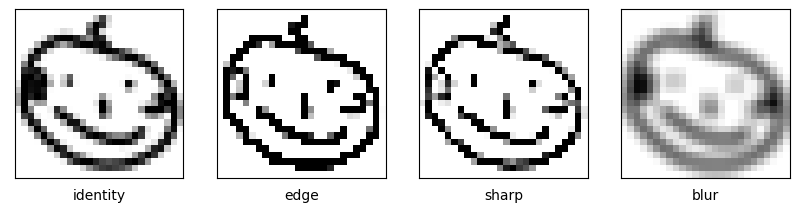

In [14]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]), cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()



## Image classification using a CNN
---

### Construct CNN using Keras functional API

- Input matches shape of images (28, 28, 1)
- Convolutional layer 32 filters, kernel size 3x3
- Pooling layer 2x2
- Another conv. layer with only 16 filters this time 3x3
- Another pooling layer 2x2
- Flatten into 10 output nodes (# of body parts)

In [ ]:
myface.shape

In [ ]:
#CNN structure

visible = Input(shape = (28,28,1))
conv1 = Conv2D(32, kernel_size = 3, activation = 'relu')(visible)
pool1 = MaxPooling2D(pool_size = 2)(conv1)
conv2 = Conv2D(16, kernel_size = 3, activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = 2)(conv2)
flat = Flatten()(pool2)
output = Dense(10, activation = 'sigmoid')(flat)

model = Model(inputs = visible, outputs = output)
model.summary()

### Compile and train the CNN image classifier 


In [ ]:
y_test[:10]

In [ ]:
#SparseCat... loss method as integer targets

model.compile(optimizer = 'adam',
              loss = 'SparseCategoricalCrossentropy',
              metrics = ['accuracy'])

In [ ]:
#Fit the model

history_model = model.fit(x = X_train, y = y_train, epochs = 20, batch_size = 32, validation_split = 0.2, shuffle = True)

In [ ]:
#Plot loss and validation loss

plt.plot(history_model.history['loss'], label = 'loss', color = 'blue')
plt.plot(history_model.history['val_loss'], label = 'val_loss', color = 'green')

plt.legend()
plt.xlabel('No. Epochs')
plt.ylabel('Loss');

### Evaluate the classification performance on the testing dataset

In [ ]:
print ('Train accuracy {:.1f}%'.format(model.evaluate(X_train, y_train)[1]*100))
print ('Test accuracy {:.1f}%'.format(model.evaluate(X_test, y_test)[1]*100))

Seems relatively good

#### Make predictions and compare

In [ ]:
#Predict which body parts
predictions = model.predict(X_test)

#Get the largest probability, i.e. which body part the model thinks the image is
y_pred = np.argmax(predictions, axis = 1)

In [ ]:
#Find where the model is guessing incorrectly

comparison = (y_pred == y_test)
wrong_predictions = np.where(comparison == False)[0]
wrong_predictions

In [ ]:
print (body_parts)

In [ ]:
#Just double check some of the incorrect predictions

print (predictions[12].argmax())
print(y_test[12])
plt.imshow(X_test[12], cmap = plt.cm.binary);

#### Plot some of the incorrect predictions

In [ ]:
plt.figure(figsize = (10, 10))

for n in range(6):

    ax = plt.subplot(1, 6, n + 1)
    bad_prediction_index = wrong_predictions[n]
    plt.imshow(X_test[bad_prediction_index], cmap = plt.cm.binary)

    # chart formatting
    type_actual = y_test[bad_prediction_index].astype(int)
    type_predicted = y_pred[bad_prediction_index].astype(int)
    
    plt.xlabel('Actual: {}'.format(body_parts[type_actual]))
    plt.title('Prediction: {}'.format(body_parts[type_predicted]), color = 'r')
    plt.xticks([])
    plt.yticks([])

#### Plot the confusion matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')

# Use the following courmap in as the cmap parameter of sns.heatmap:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(cm , cmap=colormap, annot=True, fmt=".2f")
ax.set_xticklabels(
    body_parts,
    rotation=45,
    horizontalalignment='right'
);
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_yticklabels(body_parts);
plt.show()

Makes sense that the model has a harder time distinguishing between a knee, leg, and foot. Arm confused with foot. Good at predicting faces, eyes, and mouths

Run the first layer kernels over `myface`. Can see several copies of the image, all with varying transformations

In [ ]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(8,2,2*(i)+1)

    sns.heatmap(model.layers[1].get_weights()[0][:,:,:,i][:,:,0], cmap='Greys',annot=True,fmt=".1f")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(8,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(run_kernel(myface,model.layers[1].get_weights()[0][:,:,:,i]),cmap=plt.cm.binary,norm=norm(0,1))
plt.show()


### Predict a couple of sketches made with paint

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]

    grey = np.zeros(shape = (28,28,1))
    grey[:, :, 0] = 0.2989 * r + 0.5870 * g + 0.1140 * b
    grey[:, :, 0] = grey[:, :, 0] < 0.5

    return grey

In [ ]:
img_denis = mpimg.imread('denis_face.png')     
grey_denis = rgb2gray(img_denis)    

plt.imshow(grey_denis, cmap=plt.cm.binary)
plt.show()

In [ ]:
body_parts[model.predict(np.array([grey_denis])).argmax()]

In [ ]:
img_cristina = mpimg.imread('cristina_ear.png')
grey_cristina = rgb2gray(img_cristina)    

plt.imshow(grey_cristina, cmap=plt.cm.binary)
plt.show()

In [ ]:
body_parts[model.predict(np.array([grey_cristina])).argmax()]

## Auto-encoders (3 marks)
---
In this section, we will construct and train an auto-encoder as an example of **unsupervised learning.** This type of model is made up of an **encoder** that maps an image of shape $(N,M,C)$ into a latent vector of shape $(L,)$; and a **decoder** which maps the latent vector into an image with the same shape as the original. The latent, or encoded, vector will typically be small in size compared to the input image (_i.e._ $L \ll N \times M \times C$), meaning that it is an **information bottleneck.** The aim of the auto-encoder is therefore to learn the most efficient encoding of a class of images (here: quickdraw dataset) that allows the decoder to reconstruct the original as well as possible under the bottleneck constraint.

We will break down this task into a few sub-tasks, to make it easier to get through.

#### 6. Construct the encoder (1 Marks)

* Use the `Keras` functional API to construct the encoder model. 
* The shape of the input layer should match the shape of the prepared images .
* Add some convolutional and pooling layers in a sensible configuration. 
    * Using a decreasing number of kernels for each convolutional layer (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) works quite well.
    * For this task it is worthwhile to give some thought to padding: You want to have intermediate layers with shapes that are easy to reconstruct with the decoder. As a starting point, consider using `padding='same'` for your conv. layers.
    * **See also the note below.**
* **Flatten** the output of the last convolutional layer, and use this as the latent vector. 
    * For convenience, we choose to make the latent vector have values in the range [0,1], so add the appropriate activation function to the preceeding convolutional layer.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * These methods are also very useful for debugging, when you are building your network. For instance, start with the simplest possible `Keras` model; plot the architecture using one of these methods; modify the model slightly; plot the architecture again to see the effect; _etc._
    * Make sure that the output of the encoder is indeed a bottleneck, _i.e._ that the number of output nodes is significantly smaller than the number of pixels in the image. (_Hint: A latent vector could have size $49 \ll 28 \times 28 \times 1 = 784$._)
    
**Note:** Choosing the architecture for an auto-encoder can be a bit tricky. The input images we use have shape $(28,28,1)$, and when we're pooling we typically downsample by a factor of $2$. If we use "same" padding, this means that we can go down to $(7,7,F)$ with no issues. However, if we downsample further (_e.g._ $7\to 3$) it will be tricky for the decoder to reconstruct, since upsampling would result in $3\to 6$. Therefore, to keep things simple, it may be best to not downsample further than $(7,7,F)$. However, you can still add _multiple convolutional layers in a row without pooling._

In [15]:
input_img = Input(shape = (28,28,1), name = 'input')
enc_conv1 = Conv2D(16, kernel_size = 3, activation = 'relu', padding = 'same')(input_img)
enc_pool1 = MaxPooling2D(pool_size = 2, padding = 'same')(enc_conv1)
enc_conv2 = Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same')(enc_pool1)
enc_pool2 = MaxPooling2D(pool_size = 2, padding = 'same')(enc_conv2)
enc_conv3 = Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same')(enc_pool2)
enc_conv4 = Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same')(enc_conv3)
enc_conv5 = Conv2D(1, kernel_size = 3, activation = 'sigmoid', padding = 'same')(enc_conv4)
enc_output = Flatten()(enc_conv5)

encoder = Model(inputs = input_img, outputs = enc_output, name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 2)           74  

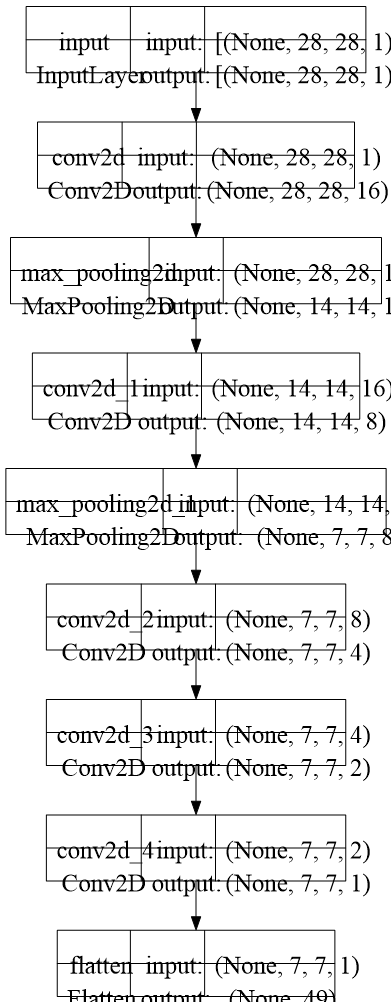

In [16]:
plot_model(encoder, show_shapes = True)

#### 7. Construct the decoder (1 Mark)

* Use the `Keras` functional API to construct the decoder model. 
* **Reshape** the latent vector to have the shape of the last convolutional layer in the encoder.
* The shape of the input layer should match the shape of the latent vector.
* Add some convolutional and **upsampling** layers in a sensible configuration. 
    * You can use the same order of kernels (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) as in the encoder.
    * Many of the notes and considerations mentioned for the encoder hold for the decoder as well.
* The output of the decoder should have the same shape as the number images. Also, choose an output activation that is appropriate to the dataset.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * As for the encoder, these methods can be very useful for debugging.

In [17]:
encoding_shape = encoder.layers[-2].output_shape[1:]  # Get the shape right before final output, which can also just be read off the summary
encoding_shape

(7, 7, 1)

In [18]:
dec_input = Input(shape = (np.prod(encoding_shape), ))
dec_rshp = Reshape(encoding_shape)(dec_input)
dec_conv1 = Conv2D(16, kernel_size = 3, activation = 'relu', padding = 'same')(dec_rshp)
dec_up1 = UpSampling2D(size = 2)(dec_conv1)
dec_conv2 = Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same')(dec_up1)
dec_up2 = UpSampling2D(size = 2)(dec_conv2)
dec_conv3 = Conv2D(4, kernel_size = 3, activation = 'relu', padding = 'same')(dec_up2)
dec_conv4 = Conv2D(2, kernel_size = 3, activation = 'relu', padding = 'same')(dec_conv3)
dec_output = Conv2D(1, kernel_size = 3, activation = 'sigmoid', padding = 'same')(dec_conv4)


decoder = Model(inputs = dec_input, outputs = dec_output, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 4)         292 

#### 8. Construct the auto-encoder (given, not marked)

Connecting the encoder and decoder to form the auto-encoder is a slightly tricky use of the `Keras` functional API, so I'll just give that to you. Assuming you have given you encoder and decoder intuitive names, the following should do the trick:

In [19]:
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 49)                1705      
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


Try to make sure that you understand what is going on here: In the `Keras` functional API, layers and even entire models work like functions (thus the name). What we're doing above is passing an input image `i` through the encoder (resulting in a latent vector); passing the output of `encoder` as the input to `decoder` (resulting in a reconstructed image); and finally using the output of `decoder` as the output of the auto-encoder.

#### 9. Compile and train the auto-encoder (1 Mark)

* Choose an appropriate loss function.
* Train for ca. 10 epochs with some data held out for validation. Time for another coffee break!
* Plot the loss curve(s).
* Perform the auto-encoding for the testing images (use the `<model>.predict()` method) and display the first couple of _(a)_ original and _(b)_ auto-encoded images to see whether the outputs resembles the original images.

In [23]:
#binary_crossentropy as the input and output image should have pixel values between 0 and 1

cae.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history_cae = cae.fit(x = X_train, y = X_train, epochs = 7, validation_split = 0.2, batch_size = 64)

Epoch 1/7
  49/2000 [..............................] - ETA: 6:18 - loss: 0.1753 - accuracy: 0.7762

KeyboardInterrupt: 

In [ ]:
#Plot loss and validation loss

plt.plot(history_cae.history['loss'], label = 'loss', color = 'blue')
plt.plot(history_cae.history['val_loss'], label = 'val_loss', color = 'green')

plt.legend()
plt.xlabel('No. Epochs')
plt.ylabel('Loss');

#### 10. Plot images in the laten space
- Predict 10 images into the laten space using the encoder only.
- Reshape the output to images and plot the laten space images. e.g. if your encoder outputs 49 features, make 7x7 image

## Anomaly detection (2 marks)
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

#### 9. Inspect the face images and the auto-encoder result (1 mark)

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed quickdraw images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

_Indicative answers:_
    
* The face images have the same shape and pixel intensity range as the preprocessed quickdraw images, so they are valid inputs to the auto-encoder.
* We can see that the auto-encoder transformed faces are _very_ unlike the input images. This is because the auto-encoder was trained to learn an efficient representation of hand-written digits which is not necessarily an efficient representation for other image domains, _e.g._ faces. This examples shows that this is clearly the case. From the point of view of the auto-encoder, images of faces are _anomalies_ in that they are fundamentally unlike the images on which it was trained, and therefore we shouldn't expect it to do a good job in encoding them.

#### 11. Perform anomaly detection (1 mark)
Imagine now that we had a dataset comprised of mostly quickdraw images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of faceses, with the same shape as the quickdraw images.

In [ ]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

The auto-encoder was trained to minimise the difference between the original and the auto-encoded image, so let's use binary cross-entropy (BCE) as our metric for the difference between an image and its auto-encoded version. The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [ ]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.